In [274]:
import time
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from ast import literal_eval
import random

pd.options.mode.chained_assignment = None
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 9999)
pd.set_option('display.max_rows', 50)
%matplotlib inline

In [275]:
df = pd.read_csv('./data/paccr_drmm_.csv', converters={"negative_sim_matrix": literal_eval,
                                                      "positive_sim_matrix": literal_eval,
                                                      "idf_softmax": literal_eval})
df = df[['query_preprocessed', 'negative_sim_matrix', 'positive_sim_matrix', 'idf_softmax']]

In [276]:
train_q = set(random.sample(list(df['query_preprocessed'].unique()), int(len(df['query_preprocessed'].unique()) * 0.9)))
dev_q = set(df['query_preprocessed'].unique()) - train_q

In [277]:
train = pd.concat([df.groupby('query_preprocessed').get_group(name) for name in train_q])
dev = pd.concat([df.groupby('query_preprocessed').get_group(name) for name in dev_q])

In [278]:
# df shuffle 
train = train.sample(frac=1).reset_index(drop=True)
dev = dev.sample(frac=1).reset_index(drop=True)

In [279]:
metadata = {'negative_sim_matrix': train['negative_sim_matrix'].values, 
            'positive_sim_matrix': train['positive_sim_matrix'].values,
            'idf_softmax': train['idf_softmax'].values}

In [280]:
metadata_dev = {'negative_sim_matrix': dev['negative_sim_matrix'].values, 
                'positive_sim_matrix': dev['positive_sim_matrix'].values,
                'idf_softmax': dev['idf_softmax'].values}  

In [281]:
lq = 6
firstk = 8
num_samples = len(train)
num_samples_dev = len(dev)

In [282]:
dev_set = {}
for key, val in metadata_dev.items():
    dev_set[key] = tf.stack([val[j] for j in range(num_samples_dev)], axis=0)

In [24]:
test = pd.read_csv('./data/paccr_drmm_test.csv', converters={"sim_matrix": literal_eval,
                                                             "idf_softmax": literal_eval})

In [10]:
del df, train, dev

In [286]:
class Conv_stack(tf.keras.layers.Layer):
    def __init__(self, lg, nf):
        super(Conv_stack, self).__init__(name='ConV_stack')
        self.lg = lg
        self.nf = nf
        self.conv_dict = {}
        for i in range(2, self.lg+1):
            self.conv_dict[i] = tf.keras.layers.Conv2D(self.nf, i, strides=(1, 1), padding='same')

    def call(self, inputs):
        inputs = tf.expand_dims(inputs, axis=-1)
        x_1 = inputs
        x = {}
        for i in range(2, self.lg+1):
            x[i] = self.conv_dict[i](inputs)
        return tf.keras.layers.concatenate([x_1] + [x[k] for k in x]) 

In [287]:
class Dim_wise_max_pooling(tf.keras.layers.Layer):
    def __init__(self, lg, nf):
        super(Dim_wise_max_pooling, self).__init__(name='dim_wise_max_pooling')
        self.lg = lg
        self.nf = nf
        
    def call(self, inputs):
        channel_range = [self.nf*i+1 for i in range(self.lg)]
        x_1 = inputs[:, :, :, 0]
        x = {}
        for i in range(2, self.lg+1):
            x[i] = tf.reduce_max(inputs[:, :, :, channel_range[i-2]:channel_range[i-1]], axis=-1)
            
        return tf.keras.layers.concatenate([x_1] + [x[k] for k in x])

In [288]:
class Row_wise_max_pooling(tf.keras.layers.Layer):
    def __init__(self, ns, lg, firstk):
        super(Row_wise_max_pooling, self).__init__(name='row_wise_max_pooling')
        self.ns = ns
        self.lg = lg
        self.firstk = firstk
        
    def call(self, inputs):
        x = {}
        for i in range(1, self.lg+1):
            x[i] = tf.math.top_k(inputs[:, :, self.firstk*(i-1):self.firstk*i], k=self.ns)[0]
            
        return tf.keras.layers.concatenate([x[k] for k in x])

In [289]:
class Idf_concat(tf.keras.layers.Layer):
    def __init__(self):
        super(Idf_concat, self).__init__(name='idf_concat')
        
    def call(self, inputs, idf):
        expand_idf = tf.expand_dims(idf, axis=-1)
        return tf.keras.layers.concatenate([inputs, expand_idf])

In [290]:
class Recurrent_Layer(tf.keras.layers.Layer):
    def __init__(self, lq, ns, lg):
        super(Recurrent_Layer, self).__init__(name='Recurrent_Layer')
        self.inputs_shape = (lq, ns*lg+1)
        self.lstm = tf.keras.layers.LSTM(units=1, input_shape=self.inputs_shape)
        
    def call(self, inputs):
        return self.lstm(inputs)

In [291]:
class PACRR(tf.keras.Model):
    def __init__(self, firstk, lq, lg, nf, ns):
        super(PACRR, self).__init__(name='PACRR')
        self.firstk = firstk
        self.lq = lq
        self.lg = lg
        self.nf = nf
        self.ns = ns
        
        self.conv_stack = Conv_stack(lg=self.lg, nf=self.nf)
        self.dim_wise_max_pooling = Dim_wise_max_pooling(lg=self.lg, nf=self.nf)
        self.row_wise_max_pooling = Row_wise_max_pooling(lg=self.lg, ns=self.ns, firstk=self.firstk)
        self.idf_concat = Idf_concat()
        self.recurrent_Layer = Recurrent_Layer(lq=self.lq, ns=self.ns, lg=self.lg)

    def call(self, inputs, idf):
        x = self.conv_stack(inputs)
        x = self.dim_wise_max_pooling(x)
        x = self.row_wise_max_pooling(x)
        x = self.idf_concat(x, idf)
        x = self.recurrent_Layer(x)
        return x

In [292]:
class Pairwise_PACRR(tf.keras.Model):
    def __init__(self, firstk, lq, lg, nf, ns):
        super(Pairwise_PACRR, self).__init__(name='Pairwise_PACRR')
        self.Pacrr = PACRR(firstk, lq, lg, nf, ns)
        
    def call(self, inputs):
        positive_sim = inputs['positive_sim_matrix']
        negative_sim = inputs['negative_sim_matrix']
        idf = inputs['idf_softmax']
        
        positive = self.Pacrr(positive_sim, idf)
        negative = self.Pacrr(negative_sim, idf)
        
        return tf.concat([positive, negative], axis=0) 
    
    def predict(self, inputs):
        sim_matrix = inputs['sim_matrix']
        idf_softmax = inputs['idf_softmax']
        rel = self.Pacrr(sim_matrix, idf_softmax)
        return rel

In [293]:
def Pairwise_ranking_loss(y_true, y_pred):
    '''
    ignore y_true
    '''
    positive_score = tf.keras.layers.Lambda(lambda x: x[:len(x)//2], output_shape= (1,))(y_pred)
    negative_score = tf.keras.layers.Lambda(lambda x: x[len(x)//2:], output_shape= (1,))(y_pred)

    return tf.keras.backend.mean(tf.math.maximum(0, 1 - positive_score + negative_score))

In [294]:
def ndcg(rel_pred, p=None, form="linear"):
    if p==None:
        p = len(rel_pred)
    if p > len(rel_pred):
        rel_pred = np.append(rel_pred, [0]*(p - len(rel_pred)))
    
    rel_true = np.sort(rel_pred)[::-1]
    discount = 1 / (np.log2(np.arange(p) + 2))

    if form == "linear":
        idcg = np.sum(rel_true[:p] * discount)
        dcg = np.sum(rel_pred[:p] * discount)
    elif form == "exponential" or form == "exp":
        idcg = np.sum([2**x - 1 for x in rel_true[:p]] * discount)
        dcg = np.sum([2**x - 1 for x in rel_pred[:p]] * discount)
    else:
        raise ValueError("Only supported for two formula, 'linear' or 'exp'")
    
    return dcg / idcg

In [295]:
tf.keras.backend.clear_session()

In [296]:
batchs = 128
def meta_dict_gen():
    i=0
    while True:
        ls = {}
        for key, val in metadata.items():
            ls[key] = tf.stack([val[j] for j in range((batchs*i)%num_samples, (batchs*(i+1))%num_samples)], axis=0)
        i+=1
        yield ls
        
dataset = tf.data.Dataset.from_generator(
    meta_dict_gen,
    output_types={k: tf.float32 for k in metadata},
    output_shapes={'negative_sim_matrix': (batchs, lq, firstk), 'positive_sim_matrix': (batchs, lq, firstk), 'idf_softmax': (batchs, lq)}
)

In [298]:
iterator = iter(dataset)
next_element = iterator.get_next()

In [266]:
firstk = 8
lq = 6
lg=5
nf=32
ns=2
n = 20
learning_rate = 1
print_step = 10

model = Pairwise_PACRR(firstk, lq, lg, nf, ns)
optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)

Pairwise_ranking_loss(y_true=None, y_pred=model(next_element))

<tf.Tensor: shape=(), dtype=float32, numpy=0.9982084>

In [267]:
loss_sum = 0
ndcg_sum = 0
step_history = []
loss_history = []
loss_history_dev = []
ndcg_history = []

start = time.time()
for step, batch_train in enumerate(dataset):
    
    with tf.GradientTape() as tape:
        logits = model(batch_train)
        loss_value = Pairwise_ranking_loss(y_true=None, y_pred=logits)
        loss_sum += loss_value 
        
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    if step % print_step == 0:
        current_loss_average = float(loss_sum)/print_step
        if step ==0:
            current_loss_average = loss_sum

        logits_dev = model(dev_set)
        current_loss_average_dev = Pairwise_ranking_loss(y_true=None, y_pred=logits_dev)
        
            
        for q in dev_q:
            ndcg_test = test[test['query_preprocessed'] == q]
            metadata_ndcg = {'sim_matrix': tf.stack([ndcg_test['sim_matrix'].values[j] for j in range(len(ndcg_test))], axis=0), 
                             'idf_softmax': tf.stack([ndcg_test['idf_softmax'].values[j] for j in range(len(ndcg_test))], axis=0)}  
            ndcg_test['rel'] = model.predict(metadata_ndcg).numpy()
            rel_pred = list(ndcg_test.sort_values(by=['rel'], axis=0, ascending=False)['median_relevance']-1)
            ndcg_sum += ndcg(rel_pred, p=n, form="exp")
        current_ndcg_average = ndcg_sum/len(dev_q)
        
        step_history.append(step)
        loss_history.append(current_loss_average)
        loss_history_dev.append(current_loss_average_dev)
        ndcg_history.append(current_ndcg_average)
        
        print("Training loss at step %d: %.5f, dev_loss : %.5f, nDCG@20 : %.5f"% (step, 
                                                                  current_loss_average, 
                                                                  current_loss_average_dev,
                                                                  current_ndcg_average))
        print("Seen so far: %s train samples, learning rate: %.4f" % ((step + 1) * batchs, learning_rate))
        ndcg_sum = 0
        loss_sum = 0
        start = time.time()
    
    if step % 500 == 0:
        learning_rate *= .1
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)

Training loss at step 0: 0.99821, dev_loss : 0.99188, nDCG@20 : 0.85387
Seen so far: 128 train samples, learning rate: 1.0000
Training loss at step 10: 0.98307, dev_loss : 0.98164, nDCG@20 : 0.84713
Seen so far: 1408 train samples, learning rate: 0.1000
Training loss at step 20: 0.97280, dev_loss : 0.96876, nDCG@20 : 0.84748
Seen so far: 2688 train samples, learning rate: 0.1000
Training loss at step 30: 0.94313, dev_loss : 0.94160, nDCG@20 : 0.84623
Seen so far: 3968 train samples, learning rate: 0.1000
Training loss at step 40: 0.88960, dev_loss : 0.88478, nDCG@20 : 0.84272
Seen so far: 5248 train samples, learning rate: 0.1000
Training loss at step 50: 0.85234, dev_loss : 0.84624, nDCG@20 : 0.85257
Seen so far: 6528 train samples, learning rate: 0.1000
Training loss at step 60: 0.83345, dev_loss : 0.84853, nDCG@20 : 0.84153
Seen so far: 7808 train samples, learning rate: 0.1000
Training loss at step 70: 0.78794, dev_loss : 0.84551, nDCG@20 : 0.84015
Seen so far: 9088 train samples, 

KeyboardInterrupt: 

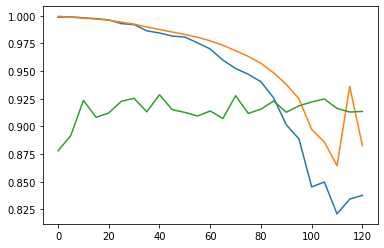

In [172]:
plt.plot(step_history, loss_history)
plt.plot(step_history, loss_history_dev)
plt.plot(step_history, ndcg_history)
plt.show()

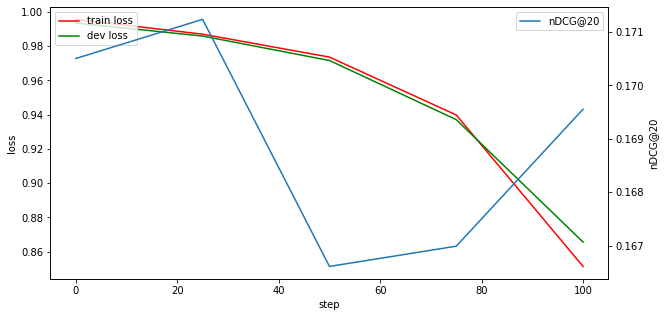

In [247]:
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('step')
ax1.set_ylabel('loss')
ax1.plot(step_history, loss_history, color='r', label='train loss')
ax1.plot(step_history, loss_history_dev, color='g', label='dev loss')
# ax1.set_ylim(0.8, 1.1)
ax1.legend(loc=2)


ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('nDCG@20')  
ax2.plot(step_history, ndcg_history, color=color, label='nDCG@20')
ax2.legend(loc=1)
# ax2.set_ylim(0.87, 0.94)
plt.show()

In [117]:
ndcg_test = test[test['query_preprocessed'] == 'nike flip flop']

metadata_ndcg = {'sim_matrix': tf.stack([ndcg_test['sim_matrix'].values[j] for j in range(len(ndcg_test))], axis=0), 
                 'idf_softmax': tf.stack([ndcg_test['idf_softmax'].values[j] for j in range(len(ndcg_test))], axis=0)}  

ndcg_test.insert(5, 'rel', model.predict(metadata_ndcg).numpy(), True)

ndcg_test.sort_values(by=['rel'], axis=0, ascending=False)[['query', 'product_title', 'median_relevance', 'rel']].head(20)

,query,product_title,median_relevance,rel
3096,nike flip flops,OP Girl's Woven Beach Flip Flop,3,0.128756
3572,nike flip flops,Girl's Circo Hailey Floral Print Flip Flop San...,2,0.128528
5675,nike flip flops,Toddler Boys' Skull Print Flip-flop,2,0.128147
1212,nike flip flops,OP Mens' Camo Flip Flop,2,0.127906
3573,nike flip flops,Avengers Toddler Boy's Flip Flop,2,0.127725
3553,nike flip flops,OP Mens' Embossed Flip Flop,2,0.127645
9664,nike flip flops,Op Boy's Everyday Flip Flop,2,0.127529
364,nike flip flops,OP Women's Beach EVA Stacked Flip-flop,2,0.127439
9599,nike flip flops,Women's Leonie Flip Flop Sandals - Assorted Co...,2,0.127233
6738,nike flip flops,Women's C9 by Champion Lindie Flip Flop Sandal...,2,0.127173


C:\Users\kwon\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [270]:
ndcg_test = test[test['query_preprocessed'] == 'nike flip flop']

metadata_ndcg = {'sim_matrix': tf.stack([ndcg_test['sim_matrix'].values[j] for j in range(len(ndcg_test))], axis=0), 
                 'idf_softmax': tf.stack([ndcg_test['idf_softmax'].values[j] for j in range(len(ndcg_test))], axis=0)}  

ndcg_test.insert(5, 'rel', model.predict(metadata_ndcg).numpy(), True)

ndcg_test.sort_values(by=['rel'], axis=0, ascending=False)[['query', 'product_title', 'median_relevance', 'rel']].head(20)

,query,product_title,median_relevance,rel
7602,nike flip flops,Women's Nike 'SolarSoft 11' Flip Flop,4,0.794189
2601,nike flip flops,"Women's Nike 'SolarSoft 11' Flip Flop, Size 6 M - Black",4,0.792521
841,nike flip flops,"Women's Nike 'SolarSoft 11' Flip Flop, Size 8 M - Black",4,0.792521
6627,nike flip flops,Women's Nike 'Flex Motion' Flip Flop,4,0.792339
4425,nike flip flops,Nike Aqua Motion Girls Flip Flops - Little Kids/Big Kids,4,0.789937
8157,nike flip flops,OP Women's Eyelit EVA Flip Flop,2,0.772066
4095,nike flip flops,Girls Hester Flip Flop Sandals - Grey/Fuchsia,4,0.768662
290,nike flip flops,Women's Letty Flip Flop Sandals,3,0.767918
3553,nike flip flops,OP Mens' Embossed Flip Flop,2,0.767454
3573,nike flip flops,Avengers Toddler Boy's Flip Flop,2,0.767167
